#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost-Regressor" data-toc-modified-id="CatBoost-Regressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><strong>CatBoost Regressor</strong></a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><strong>LinearRegression</strong></a></span></li><li><span><a href="#LGBM-Regressor" data-toc-modified-id="LGBM-Regressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span><strong>LGBM Regressor</strong></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

RDM=12345

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

'**Общая информация датафрейма**'

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

'**Просмотр статистических данных**'

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


'**Вывод первых пяти строк датафрейма**'

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


'**Вывод количесва дубликатов датафрейма**'

26415

'**Вывод количесва пропущеных значений датафрейма**'

num_orders    0
dtype: int64

'**Гистограммы распеделения**'

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

None

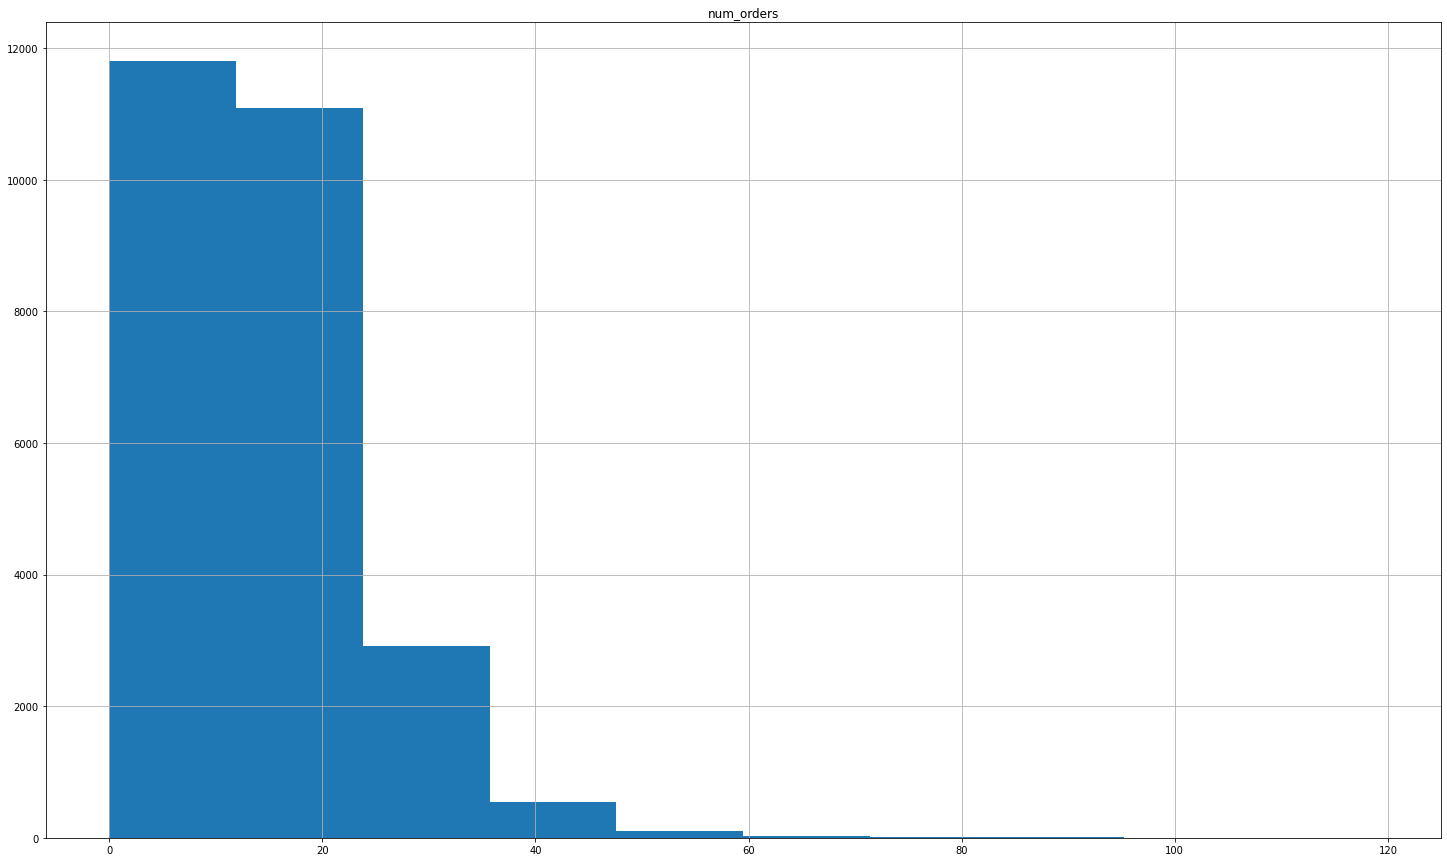

In [3]:
def fun_date(data):
    display ('**Общая информация датафрейма**')
    display(data.info())
    print(' ')
    display('**Просмотр статистических данных**')
    display(data.describe(include= 'all').T)
    print(' ')
    display('**Вывод первых пяти строк датафрейма**')
    display(data.head())
    print(' ')
    display('**Вывод количесва дубликатов датафрейма**')
    display(data.duplicated().sum())
    print(' ')
    display('**Вывод количесва пропущеных значений датафрейма**')
    display(data.isnull().sum())
    print(' ')
    display('**Гистограммы распеделения**')
    display(data.hist(figsize=(25,15)));
    
display(fun_date(df))

In [4]:
df.sort_index(inplace=True)
df=df.resample('1H').sum()

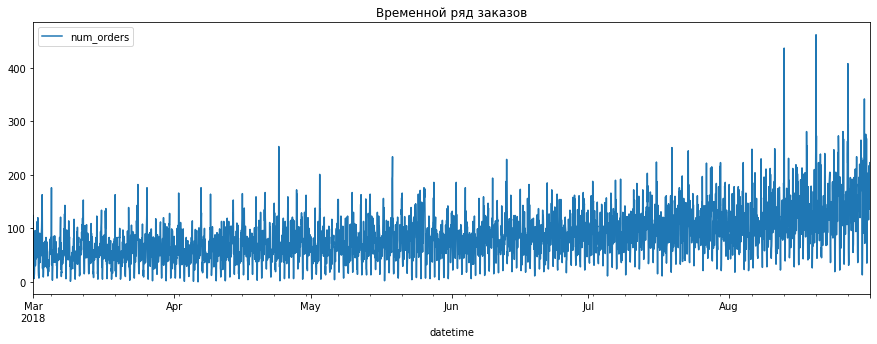

In [5]:
df.plot(figsize=(15,5));
plt.title('Временной ряд заказов');

In [6]:
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

for lag in range(1,2):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(1)

df['rolling_mean'] = df['num_orders'].shift(fill_value=0).rolling(2).mean()
df.head()

,num_orders,month,day,day_of_week,hour,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,62.0
2018-03-01 02:00:00,71,3,1,3,2,85.0,104.5
2018-03-01 03:00:00,66,3,1,3,3,71.0,78.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,68.5


Итак  мы изучили данные , пропуски\дубликаты отсутствуют. Произвели ресемплирование по часу

## Анализ

In [7]:
decomposed = seasonal_decompose(df['num_orders'])

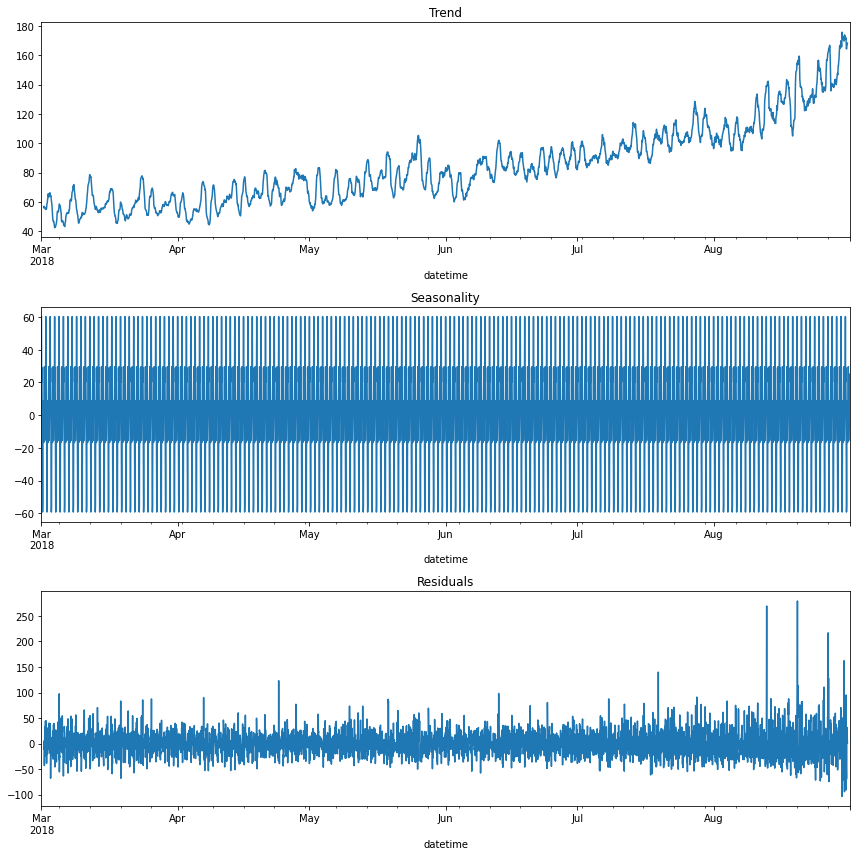

In [8]:
plt.figure(figsize=(12,12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

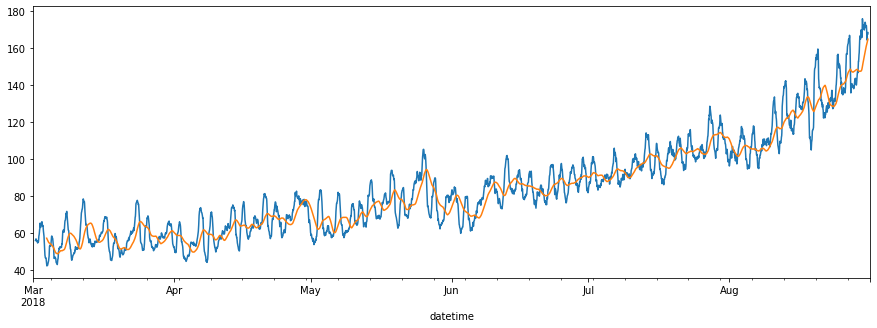

In [9]:
decomposed.trend.plot(figsize=(15,5));
decomposed.trend.rolling(60).mean().plot();

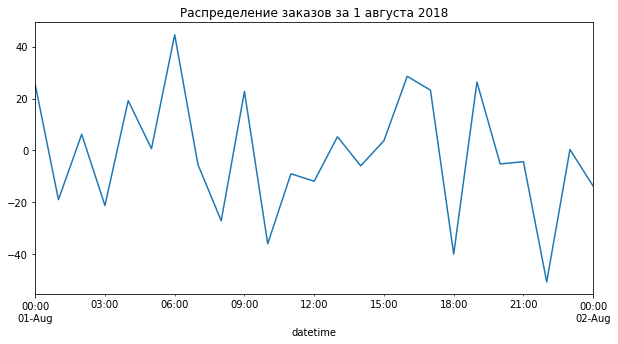

In [10]:
plt.figure(figsize=(10,5))
decomposed.resid['2018-08-01 00:00':'2018-08-02 00:00'].plot()
plt.title('Распределение заказов за 1 августа 2018')
plt.show()

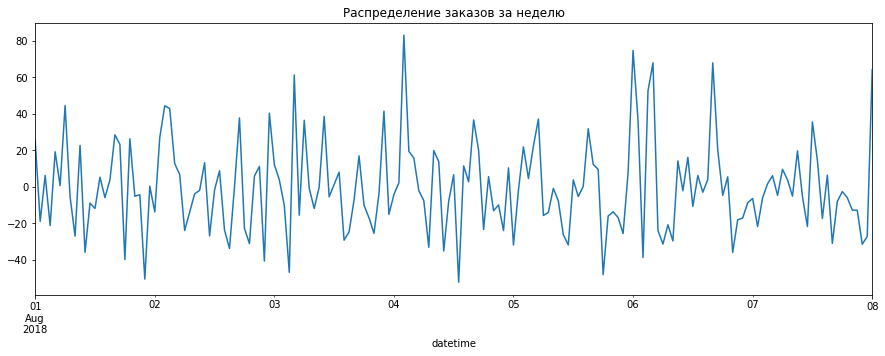

In [11]:
plt.figure(figsize=(15,5))
decomposed.resid['2018-08-01 00:00':'2018-08-08 00:00'].plot()
plt.title('Распределение заказов за неделю')
plt.show()

**Вывод:**
Т.о., видим, что тренд восходящий, имеется сезонность внутри дня: пики в райне 6 и 9ч утра и 17ч, 19 ч вечера

## Обучение

In [12]:
df=df.dropna()
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)

### **CatBoost Regressor**

In [13]:
%%time
grid = {'learning_rate': [0.01, 0.1],
        'depth': [5, 10]
       }

scoring_fit='neg_root_mean_squared_error'
model_cat = CatBoostRegressor(loss_function="RMSE")

grs=GridSearchCV( model_cat, param_grid =grid, cv=TimeSeriesSplit(n_splits=4).split(x_train), scoring=scoring_fit)
grs.fit(x_train, y_train)

0:	learn: 29.3577132	total: 47ms	remaining: 47s
1:	learn: 29.2534647	total: 47.7ms	remaining: 23.8s
2:	learn: 29.1783600	total: 48.5ms	remaining: 16.1s
3:	learn: 29.0468300	total: 49ms	remaining: 12.2s
4:	learn: 28.9126737	total: 49.6ms	remaining: 9.88s
5:	learn: 28.7870817	total: 50.2ms	remaining: 8.32s
6:	learn: 28.6565535	total: 50.8ms	remaining: 7.21s
7:	learn: 28.5784231	total: 51.2ms	remaining: 6.35s
8:	learn: 28.4548223	total: 51.7ms	remaining: 5.69s
9:	learn: 28.3319804	total: 52.1ms	remaining: 5.16s
10:	learn: 28.2331258	total: 52.6ms	remaining: 4.72s
11:	learn: 28.1121209	total: 53ms	remaining: 4.37s
12:	learn: 27.9952037	total: 53.6ms	remaining: 4.07s
13:	learn: 27.8747519	total: 54.3ms	remaining: 3.83s
14:	learn: 27.7744211	total: 54.9ms	remaining: 3.6s
15:	learn: 27.6448912	total: 55.4ms	remaining: 3.41s
16:	learn: 27.5253634	total: 56.1ms	remaining: 3.24s
17:	learn: 27.4424573	total: 56.7ms	remaining: 3.09s
18:	learn: 27.3423416	total: 57.3ms	remaining: 2.96s
19:	learn: 2

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7ff2e714e270>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7ff2e6e80490>,
             param_grid={'depth': [5, 10], 'learning_rate': [0.01, 0.1]},
             scoring='neg_root_mean_squared_error')

In [16]:
print(grs.best_params_)

{'depth': 5, 'learning_rate': 0.01}


In [17]:
%%time
model_cat = CatBoostRegressor(loss_function="RMSE", depth=5, learning_rate=0.01)
model_cat.fit(x_train, y_train, verbose=100);

0:	learn: 38.4913849	total: 1.13ms	remaining: 1.13s
100:	learn: 28.7856012	total: 95.4ms	remaining: 849ms
200:	learn: 25.8341490	total: 187ms	remaining: 744ms
300:	learn: 24.6340977	total: 276ms	remaining: 642ms
400:	learn: 23.8912869	total: 365ms	remaining: 545ms
500:	learn: 23.3545579	total: 456ms	remaining: 454ms
600:	learn: 22.8164999	total: 546ms	remaining: 363ms
700:	learn: 22.3852096	total: 635ms	remaining: 271ms
800:	learn: 21.9749715	total: 728ms	remaining: 181ms
900:	learn: 21.6688472	total: 816ms	remaining: 89.7ms
999:	learn: 21.3314215	total: 902ms	remaining: 0us
CPU times: user 981 ms, sys: 128 ms, total: 1.11 s
Wall time: 1.7 s


### **LinearRegression**

In [18]:
%%time
model_linReg = LinearRegression()
model_linReg.fit(x_train, y_train)

CPU times: user 1.61 ms, sys: 3.94 ms, total: 5.54 ms
Wall time: 4.1 ms


LinearRegression()

### **LGBM Regressor**

In [19]:
%%time

scoring_fit='neg_root_mean_squared_error'

model_lt = lgb.LGBMRegressor()

param_grid = {'max_depth': range(8,9) ,"learning_rate": [0.01,0.1]}

gs = GridSearchCV( model_lt, param_grid,  cv=TimeSeriesSplit(n_splits=4).split(x_train) , scoring=scoring_fit)

fitted_lt = gs.fit(x_train, y_train)

CPU times: user 7.6 s, sys: 32.7 ms, total: 7.63 s
Wall time: 7.69 s


In [20]:
print(gs.best_params_)

{'learning_rate': 0.1, 'max_depth': 8}


In [21]:
%%time
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, y_test)

params ={'metric': 'l2', 'max_depth': 8,"random_state": RDM,"learning_rate":0.1}

model_lgb = lgb.train(params, d_train, verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 3973, number of used features: 6
[LightGBM] [Info] Start training from score 78.279134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

## Тестирование

In [22]:
predict_model = model_cat.predict(x_test, verbose=0)
rmse_cat = mean_squared_error(y_test, predict_model)**(0.5)
mae_cat = mean_absolute_error(y_test, predict_model)
print('rmse Catboost =', rmse_cat)
print('mae Catboost=', mae_cat)

rmse Catboost = 46.294705414823206
mae Catboost= 35.03087083933985


In [23]:
predict_model_linReg = model_linReg.predict(x_test)
rmse_linReg = mean_squared_error(y_test, predict_model_linReg)**(0.5)
mae_linReg = mean_absolute_error(y_test, predict_model_linReg)
print('rmse LR =', rmse_linReg)
print('mae LR =', mae_linReg)

rmse LR = 52.72398473006967
mae LR = 40.30642088780627


In [24]:
predict_model_lgb = model_lgb.predict(x_test)

rmse_lgb = mean_squared_error(y_test, predict_model_lgb)**(0.5)
mae_lgb = mean_absolute_error(y_test, predict_model_lgb)
print('rmse lgb=', rmse_lgb )
print('mae lgb=', mae_lgb )

rmse lgb= 42.714063939084895
mae lgb= 31.68549784862423


In [25]:
table = pd.DataFrame(columns=['name','rmse','mae'])
tab =[
    ['lgb', rmse_lgb, mae_lgb], ['Linear Regression', rmse_linReg, mae_linReg], 
    ['CatBoost', rmse_cat, mae_cat]
    ]
index_table =0
for t in tab:
    table.loc[index_table]= t
    index_table +=1

table

,name,rmse,mae
0,lgb,42.714064,31.685498
1,Linear Regression,52.723985,40.306421
2,CatBoost,46.294705,35.030871


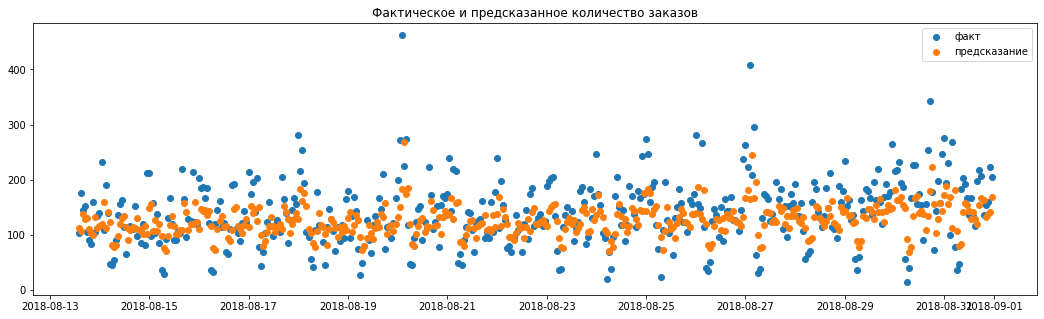

In [27]:
plt.figure(figsize=(18,5))
plt.scatter(y=y_test, x=y_test.index)
plt.scatter(y=predict_model_linReg, x=y_test.index)
plt.title('Фактическое и предсказанное количество заказов')
plt.legend(['факт', 'предсказание']);

**ВЫВОД:**

Т.о., время обучения моделей:
 - catboost 1.7 с
 - Linear Regression 4мс
 - lgb 882 мс
 
Наименьшие ошибки MAE  31,7 и RMSE 42.7 у lgb. C учетом минимального времени обучения, в данном случае лучшая модель LGBM Regressor.